# Assignment 3 - Using Stan & other exercises

In [1]:
# Setup 
import numpy as np
import matplotlib.pyplot as plt
import pystan

In [2]:
!wget https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv

--2021-02-18 13:49:34--  https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv
Resolving course-resources.minerva.kgi.edu (course-resources.minerva.kgi.edu)... 54.192.23.12, 54.192.23.117, 54.192.23.107, ...
Connecting to course-resources.minerva.kgi.edu (course-resources.minerva.kgi.edu)|54.192.23.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46848 (46K)
Saving to: ‘call-center.csv.1’

call-center.csv.1   100%[===================>]  45.75K   158KB/s    in 0.3s    

2021-02-18 13:49:35 (158 KB/s) - ‘call-center.csv.1’ saved [46848/46848]



## 1. Implement models in Stan

### 1. Call center data set

To model the call center data set we use Bayesian inference. To calculate the posterior we use an exponential likelihood with a gamma prior. We want to estimat the number of calls per minute for the 13th hour of the call center data set.

In [3]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


To remind ourselves let's look at the distribution of the waiting times per hour.

In [4]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

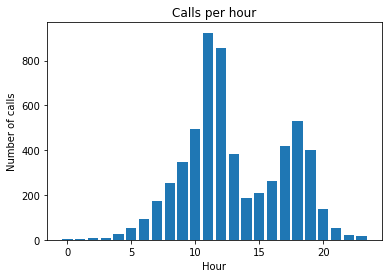

In [5]:
plt.bar(
    x = list(range(len(waiting_times_per_hour))), 
    height = [len(x) for x in waiting_times_per_hour]
)
plt.xlabel('Hour')
plt.ylabel('Number of calls')
plt.title('Calls per hour')
plt.show()

Specifically looking at the 13th hour, we can see the distribtuion of the waiting times of the 13th hour.

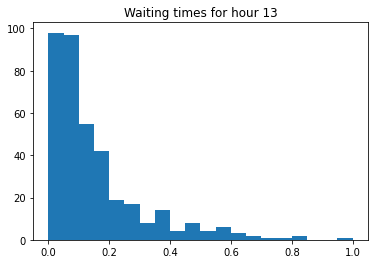

In [6]:
# Plot histogram of waiting times for hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [7]:
stan_code = '''

data {
    int <lower=1> N;   // Sample size
    vector[N] y;       // Outcome
}

parameters {
    real lambda;  // the parameter for our posterior model
}

model {
    real alpha;
    real beta;
    alpha <- 1;
    beta <- 0.25;

    lambda ~ gamma(alpha, beta);     // Prior
    y ~ exponential(lambda);
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_114c5022f986fd27b4e15f6c643ea5cb NOW.


In [8]:
# Results for one row (father = 0)
stan_data = {
    'N': len(waiting_times_hour),
    'y': waiting_times_hour
}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_114c5022f986fd27b4e15f6c643ea5cb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.36  8.6e-3   0.32   5.74   6.14   6.35   6.57   6.98   1378    1.0
lp__   321.21    0.02   0.68 319.27 321.06 321.47 321.64 321.69   1987    1.0

Samples were drawn using NUTS at Thu Feb 18 13:50:40 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
